# Test the world gen

The following code is a Python implementation of the Perlin noise as is in the Rust code. It should allow to find easily nice parameters before applying them to the code.

## Re-implementation of the code

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Perlin Noise class

Implementation of the Perlin noise for a single scale. The gradient is computed using a seed and the coordinate to have a deterministic noise.

In [49]:
SCALE_LEVEL_PERLIN = 5

class PerlinNoise:
    def __init__(self, seed, scale):
        self.seed = seed
        self.scale = scale
        self.gradients = {}

    def closest_corner(self, coord):
        x, y = coord[0] / self.scale, coord[1] / self.scale
        return np.floor([x, y]).astype(int)

    def get_or_generate_gradient(self, corner):
        if tuple(corner) not in self.gradients:
            random.seed(hash((self.seed, tuple(corner))))
            gradient = np.random.uniform(-1, 1, size=(2,))
            self.gradients[tuple(corner)] = gradient / np.linalg.norm(gradient)
        return self.gradients[tuple(corner)]

    def at(self, coord):
        xc, yc = self.closest_corner(coord)
        corners = np.array([[xc, yc], [xc + 1, yc], [xc, yc + 1], [xc + 1, yc + 1]])

        xr, yr = (coord[0] / self.scale - xc, coord[1] / self.scale - yc)

        gradients = np.array([self.get_or_generate_gradient(corner) for corner in corners])
        
        a = corners - np.array(coord) / self.scale
        b = gradients
        values = np.zeros(len(a))
        for i in range(len(a)): 
          values[i] = np.dot(a[i], b[i])

        return self.lerp(self.fade(yr), self.lerp(self.fade(xr), values[0], values[1]), self.lerp(self.fade(xr), values[2], values[3]))
        

    @staticmethod
    def fade(t):
        return t * t * t * (t * (t * 6 - 15) + 10)

    @staticmethod
    def lerp(t, a, b):
        return a + t * (b - a)

## Multiscale Perlin

In [50]:
class MultiscalePerlinNoise:
    def __init__(self, seed, scales, amplitudes):
        self.seed = seed
        self.scales = scales
        self.amplitudes = amplitudes
        self.perlin_noises = [PerlinNoise(seed + i, scales[i]) for i in range(SCALE_LEVEL_PERLIN)]

    def at(self, coord):
        return sum(self.amplitudes[i] * self.perlin_noises[i].at(coord) for i in range(SCALE_LEVEL_PERLIN))

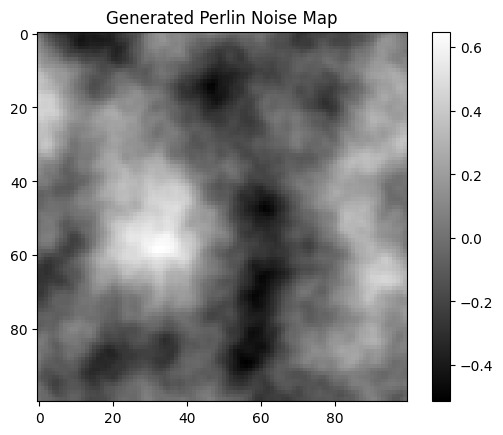

In [52]:
# Function to generate and display a small map using Perlin noise
def generate_map(seed=0, width=100, height=100):
    scales = [50, 25, 12.5, 6.25, 3.125]
    amplitudes = [1.0, 0.5, 0.25, 0.125, 0.0625]

    noise_gen = MultiscalePerlinNoise(seed, scales, amplitudes)

    map_data = np.zeros((width, height))
    for i in range(width):
        for j in range(height):
            map_data[i, j] = noise_gen.at([i, j])

    plt.imshow(map_data, cmap='gray')
    plt.title("Generated Perlin Noise Map")
    plt.colorbar()
    plt.show()

# Example of generating a small map
generate_map(seed=42)